<a href="https://colab.research.google.com/github/pachterlab/CGCCP_2023/blob/main/Example/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running biVI


This notebook demonstrates how to preprocess and reformat an anndata object with spliced and unspliced count matrices (produced using kb_pipeline.sh) for $biVI$.


Note: after installing requirements and packages, the runtime may need to be restarted before importing packages!

### Clone GitHub Repository

In [1]:
!git clone https://github.com/pachterlab/CGCCP_2023.git
%cd /content/CGCCP_2023/

Cloning into 'CGCCP_2023'...
remote: Enumerating objects: 1379, done.
remote: Counting objects: 100% (346/346), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 1379 (delta 181), reused 328 (delta 174), pack-reused 1033
Receiving objects: 100% (1379/1379), 68.38 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (704/704), done.
/content/CGCCP_2023


### Install and import necessary packages

In [2]:
%%bash
pip uninstall torchmetrics -y # need for compatibility with scVI version
pip install -qr ./Manuscript/analysis/requirements.txt
pip install -q ./BIVI/


# NOTE: you may now need to restart your kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.1/708.1 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [3]:
# import packages

import os, sys
sys.path.append('../')

import time

# numbers
import numpy as np

# sc
import anndata
import scanpy as sc

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# biVI
from BIVI import biVI

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


/usr/local/lib/python3.10/dist-packages/BIVI


In [4]:
%cd ./Example/

/content/CGCCP_2023/Example


## Load in and filter data

Process data to include only high quality cells (using the spliced matrix).

Use Scanpy to filter for cells with a minimum of 200 genes, and for genes that occur in a minimum of 3 cells. Then, annotate mitochondrial genes and remove cells if more than 30% of their counts are of mitochondrial gene. Also remove cells with fewer than 1,000 counts (based on the knee plot).

Next, select highly variable genes. First normalize such that the counts for all cells sum to 10,000 and log1p transforming the data.

Finally, select top 2,000 highly variable genes and subset the data matrix for those genes.

In [5]:
t1 = time.time()

In [6]:
data_path = 'pbmc_1k_v3/counts_filtered/adata.loom'
adata = sc.read_loom(data_path)


if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()

adata.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:1

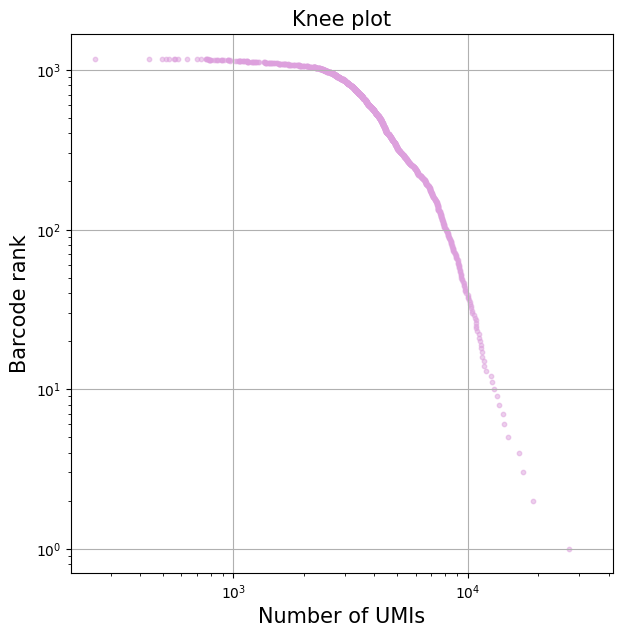

In [7]:
# plot rank vs number of UMIs for all cells

num_umi = np.array(adata.X.sum(axis=1).flatten())[0]
num_umi_sorted = np.sort(num_umi)[::-1]

# Plotting

# barcodes by # UMIs
fs = 15

fig,ax = plt.subplots(1,1,figsize=(7,7))

ax.scatter(x = num_umi_sorted,y = range(len(num_umi)),color='plum',s=10,alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of UMIs',fontsize=fs)
ax.set_ylabel('Barcode rank',fontsize=fs)
ax.set_title(f'Knee plot',fontsize = fs)
ax.grid()

In [8]:
# filter using scanpy for a minimum number of cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


## Further filtering
adata = adata[adata.obs.total_counts > 1000, :]
adata = adata[adata.obs.pct_counts_mt < 30, :]

# Normalize to get highly variable genes
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to highly variable genes
adata = adata[:, adata.var.highly_variable]

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Reformat data for $biVI$

Reformating an anndata for *biVI* is quite simple -- simply concatenate the unspliced and spliced matrices along the cell axis.

In [9]:
adata_old = adata

# separate spliced and unspliced layers
adata_spliced   = anndata.AnnData(adata.layers['spliced'])
adata_unspliced = anndata.AnnData(adata.layers['unspliced'])

adata_spliced.var = adata.var.copy()
adata_unspliced.var = adata.var.copy()

# annotate spliced vs unspliced genes
adata_spliced.var['Spliced']   = True
adata_unspliced.var['Spliced'] = False

# add a -u to unspliced gene names
adata_unspliced.var_names = adata_unspliced.var_names + '-u'

# NOTICE -- ORDER IS IMPORTANT -- concatenate so that matrices are ordered unspliced, spliced
adata = anndata.concat([adata_unspliced,adata_spliced],axis=1)

## Create a counts layer to use in training
adata.layers["counts"] = adata.X.copy() # preserve counts

# Update obs,var
adata.obs = adata_old.obs.copy()

## Set up and train a $biVI$ model

First, set up data with *biVI*. Next, define a *biVI* model. The following model choices (with argument "mode") are available:


1. "Bursty" : **Bursty** model of transcription
2. "NBcorr" : **Extrinsic** model of transcription, in which nascent and mature RNA are distributed according to two correlated Negative Binomial distributions
3. "Poisson" : **Constitutive** model of transcription, in which nascent and mature RNA are distributed according to two independent Poisson distributions

In [10]:
# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(adata,layer="counts")

# model arguments
model_args = {    'n_latent'     : 10,
                  'n_layers'     : 3,
                  'dispersion'   : 'gene',
                  'THETA_IS' : 'NAS_SHAPE',
                  'n_hidden'     : 128,
                  'dropout_rate' :  0.1,
                  'log_variational'    :  True,
                  'latent_distribution':  'normal',
                  }


# define biVI model
model = biVI.biVI(adata,mode='Bursty',**model_args)

/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


{'n_input': 4000, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


Now, set up training plan and train the model!

In [11]:
# training plan parameters
max_epochs = 100

plan_kwargs = {'lr' : 0.001,
               'n_epochs_kl_warmup' : max_epochs/2,
                }

In [12]:
model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training ba

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 100/100: 100%|██████████| 100/100 [01:51<00:00,  1.31s/it, loss=984, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it, loss=984, v_num=1]


## Visualize training results

How did the loss decrease over training epochs?

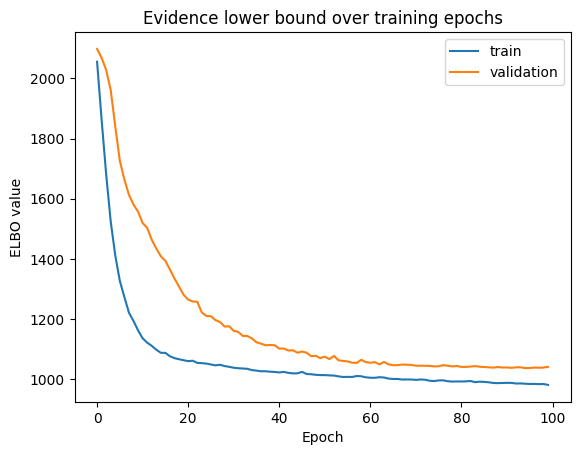

In [13]:
# plot history
plt.plot(model.history["elbo_train"], label="train")
plt.plot(model.history["elbo_validation"], label="validation")
plt.title("Evidence lower bound over training epochs")
plt.xlabel('Epoch')
plt.ylabel('ELBO value')
plt.legend()

## Explore inferred parameters and latent spaces

In [14]:
# extract latent space and parameters, can use for clustering
latent_representation = model.get_latent_representation(adata)

# add latent to anndata object
adata.obsm['latent_representation'] = latent_representation

# get likelihood parameters
parameters = model.get_likelihood_parameters(adata)

Bursty mode, getting parameters


In [15]:
# what parameters are inferred?
for key in parameters.keys():
  print(key)

mean
dispersions
unspliced_means
spliced_means
burst_size
rel_splicing_rate
rel_degradation_rate


The example dataset is a human peripheral blood mononuclear cell (PBMC) dataset from 10x Genomics.

Marker genes for the three predominant cell types in PBMCs (T cells, B cells, and monocytes) can now be investigated in terms of their parameters (burst size, relative degradation rate, and relative splicing rate).

Let's first visualize the marker genes for each cell separate out in parameter space (degradation rate versus burst size).


Marker genes:
1. *Cd2* for T cells
2. *Csta* for B cells
3. *Cd22* for monocytes



In [16]:
# locate the marker genes
cd2_index = np.where(adata.var['gene_name']=='CD2')[0][0]
csta_index = np.where(adata.var['gene_name']=='CSTA')[0][0]
cd22_index = np.where(adata.var['gene_name']=='CD22')[0][0]

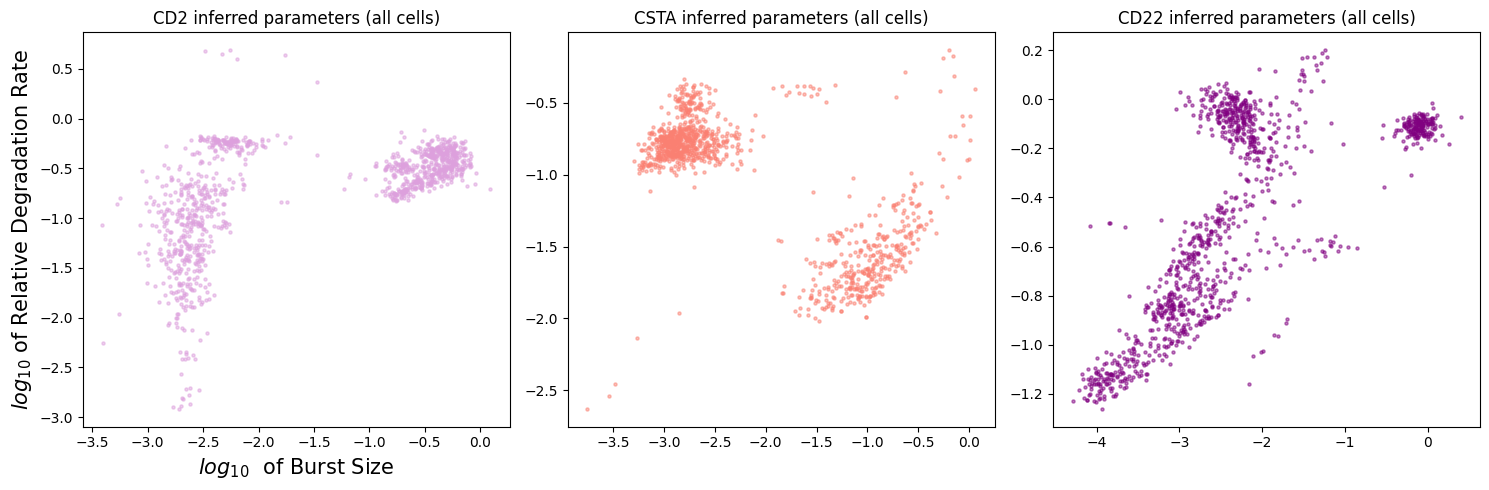

In [17]:
fig, ax = plt.subplots(1,3,figsize=(15,5))


ax[0].scatter(np.log10(parameters['burst_size'][:,cd2_index]),np.log10(parameters['rel_degradation_rate'][:,cd2_index]),
              alpha = 0.5, s = 5, color= 'plum')
ax[0].set_xlabel('$log_{10}$  of Burst Size', fontsize = 15)
ax[0].set_ylabel('$log_{10}$ of Relative Degradation Rate',fontsize = 15)
ax[0].set_title('CD2 inferred parameters (all cells)')

ax[1].scatter(np.log10(parameters['burst_size'][:,csta_index]),np.log10(parameters['rel_degradation_rate'][:,csta_index]),
              alpha = 0.5, s = 5, color= 'salmon')
ax[1].set_title('CSTA inferred parameters (all cells)')


ax[2].scatter(np.log10(parameters['burst_size'][:,cd22_index]),np.log10(parameters['rel_degradation_rate'][:,cd22_index]),
              alpha = 0.5, s = 5, color= 'purple')
ax[2].set_title('CD22 inferred parameters (all cells)')

plt.tight_layout()

Cells separate out by burst size and degradation of these three marker genes-- likely the cell types they mark show increased burst size relative other cells.


### Latent Space Structure


Plotting the top 2 PCA components of the latent space and cell-type marker gene expression shows that the latent space captures underlying cell structure, presumable that of cell type.


Points are colored by expression level of spliced marker genes.


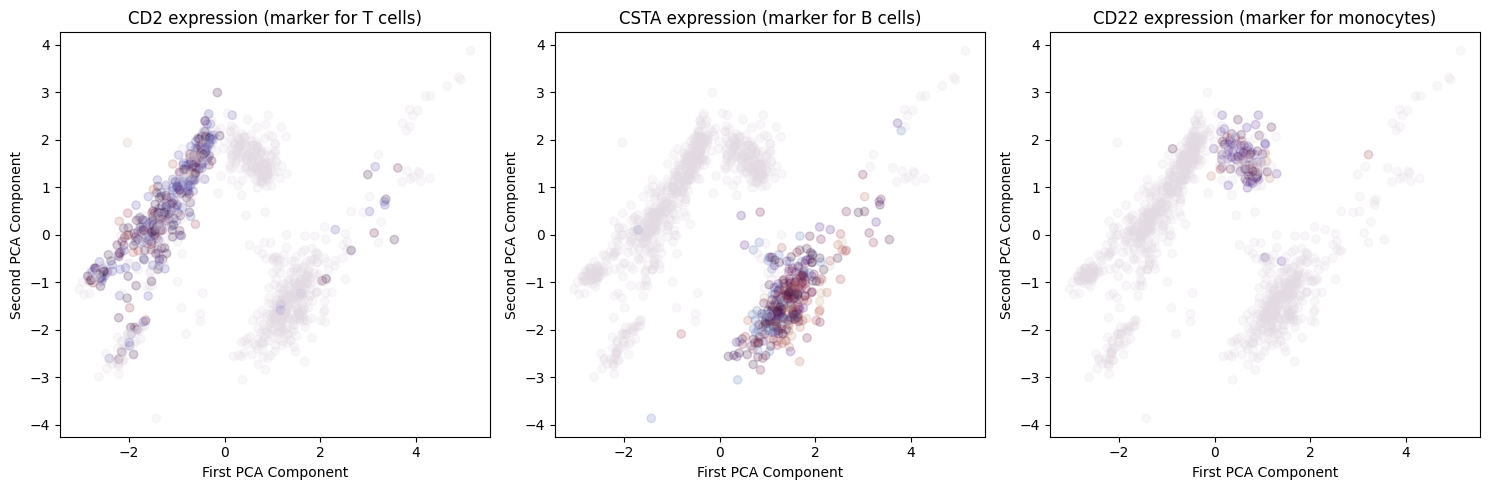

In [19]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

X_pca = sc.tl.pca(adata.obsm[f'latent_representation'], svd_solver='arpack')
marker_abundance = adata[:,adata.var['gene_name']=='CD2']
ax[0].scatter(X_pca[:,0],X_pca[:,1],c=np.log10(np.asarray(marker_abundance.layers['counts'][:,1].todense()).squeeze()+1),
                cmap='twilight',
                alpha=.2)
ax[0].set_xlabel('First PCA Component')
ax[0].set_ylabel('Second PCA Component')
ax[0].set_title(f'CD2 expression (marker for T cells)')



marker_abundance = adata[:,adata.var['gene_name']=='CSTA']
ax[1].scatter(X_pca[:,0],X_pca[:,1],c=np.log10(np.asarray(marker_abundance.layers['counts'][:,1].todense()).squeeze()+1),
                cmap='twilight',
                alpha=.2)
ax[1].set_xlabel('First PCA Component')
ax[1].set_ylabel('Second PCA Component')
ax[1].set_title(f'CSTA expression (marker for B cells)')

marker_abundance = adata[:,adata.var['gene_name']=='CD22']
ax[2].scatter(X_pca[:,0],X_pca[:,1],c=np.log10(np.asarray(marker_abundance.layers['counts'][:,1].todense()).squeeze()+1),
                cmap='twilight',
                alpha=.2)
ax[2].set_xlabel('First PCA Component')
ax[2].set_ylabel('Second PCA Component')
ax[2].set_title(f'CD22 expression (marker for monocytes)')


plt.tight_layout();

# Shared parameter: Gene vs. Gene-Cell

$biVI$ allows the user to run in two modes.

1. One parameter is shared for a gene across all cells (which the user can specify by passing the following model arguments):
  * <code>dispersion = 'gene', THETA_IS = 'NAS_SHAPE'</code>. The shared parameter is $k/\beta$, or relative splicing rate will be the same across all cells for a given gene.
  * <code>dispersion = 'gene', THETA_IS = 'MAT_SHAPE'</code>. The shared parameter is $k/\gamma$, or relative degradation rate will be the same across all cells for a given gene.
  * <code>dispersion = 'gene', THETA_IS = 'B'</code>. The shared parameter is $b$, or burst size will be the same across all cells for a given gene.

2. All cells and genes have inferred a unique burst size, relative splicing rate, and relative degradation rate by passing the following model argument:
  * <code>dispersion = 'gene-cell' </code>


In the above example, the dispersion factor is (as is the default) set to be <code>'gene'</code>, and the shared parameter is <code>'NAS_SHAPE'</code> or $1/\beta$. This means each gene's splicing rate will be shared across cells.


Below is an example of defining a model to get unique values for each cell's splicing rate.  


In [ ]:
# model arguments
model_args_2 = {    'n_latent'     : 10,
                  'n_layers'     : 3,
                  'dispersion'   : 'gene-cell',
                  'n_hidden'     : 128,
                  'dropout_rate' :  0.1,
                  'log_variational'    :  True,
                  'latent_distribution':  'normal',
                  }


# define biVI model
model_2 = biVI.biVI(adata,mode='Bursty',**model_args_2)

In [ ]:
t2 = time.time()

print(f'This notebook took {t2-t1:.3f} seconds to run.')

This notebook took 115.778 seconds to run.


In [ ]:
print(f'This notebook took {(t2-t1)/60:.3f} minutes to run.')

This notebook took 1.930 minutes to run.
